In [24]:
import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison

model_dir = '/om2/user/msaddler/pitchnet/saved_models/'
master_list = [
    ('PND_v04_JWSS_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', ''),
    ('PND_v04_JWSS_halflowpassnoise_v00_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% lowpass filt noise (100-200Hz)'),
    ('PND_v04_JWSS_halflowpassnoise_v01_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% lowpass filt noise (50-500Hz)'),
    ('PND_v04_JWSS_halfbandpass_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% bandpass filt signal'),

#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Train 1x BW, Test 1x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_test_rsb2xBW_results_dict.json', 'Train 1x BW, Test 2x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_test_rsb3xBW_results_dict.json', 'Train 1x BW, Test 3x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Train 1x BW, Test 1x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_rsb2xBW_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Train 2x BW, Test 2x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_rsb2xBW_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Train 3x BW, Test 3x BW'),

#     ('PND_v04_JWSS_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Phase-locking up to ~5000 Hz'),
#     ('PND_v04_JWSS_ANlowpass1000Hz_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Phase-locking up to 1000 Hz'),
#     ('PND_v04_JWSS_ANlowpass0050Hz_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Phase-locking up to 50 Hz'),
]

model_keys = []
results_dicts = {}
master_count = 0
for fn_regex, model_key in master_list:
    results_dicts[model_key] = []
    model_keys.append(model_key)
    if not fn_regex[0] == '/': fn_regex = os.path.join(model_dir, fn_regex)
    for results_dict_fn in sorted(glob.glob(fn_regex)):
        master_count = master_count + 1
        with open(results_dict_fn) as f:
            results_dicts[model_key].append(json.load(f))

print('Loaded results from {} file'.format(master_count))


Loaded results from 12 file


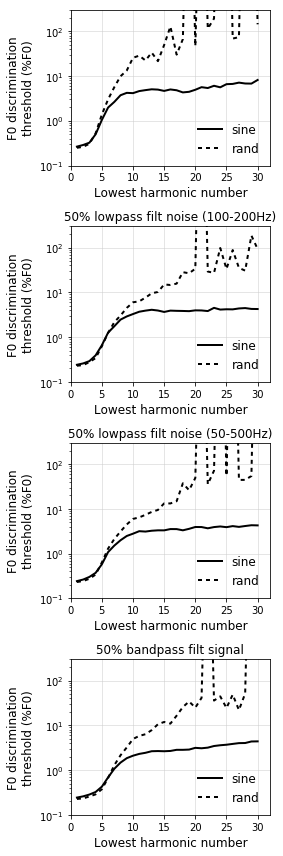

In [26]:
def make_bernox_threshold_plot(ax, results_dict_input,
                               title_str=None,
                               legend_on=True,
                               include_yerr=False,
                               sine_plot_kwargs={},
                               rand_plot_kwargs={}):
    '''
    Helper function for plotting Bernstein & Oxenham (2005) experiment
    F0 discrimination thresholds as a function of lowest harmonic number.
    '''
    if isinstance(results_dict_input, dict):
        results_dict = results_dict_input
        if 'f0dl_stddev' not in results_dict.keys():
            results_dict['f0dl_stddev'] = [0] * len(results_dict['f0dl'])
    elif isinstance(results_dict_input, list):
        f0dls = np.array([rd['f0dl'] for rd in results_dict_input])
        results_dict = {
            'phase_mode': results_dict_input[0]['phase_mode'],
            'low_harm': results_dict_input[0]['low_harm'],
            'f0dl': np.mean(f0dls, axis=0),
            'f0dl_stddev': np.std(f0dls, axis=0),
        }
    else:
        raise ValueError("INVALID results_dict_input")
    
    phase_mode_list = np.array(results_dict['phase_mode'])
    low_harm_list = np.array(results_dict['low_harm'])
    f0dl_list = np.array(results_dict['f0dl'])
    f0dl_stddev_list = np.array(results_dict['f0dl_stddev'])
    unique_phase_modes = np.unique(phase_mode_list)
    for phase_mode in unique_phase_modes:
        x = low_harm_list[phase_mode_list == phase_mode]
        y = f0dl_list[phase_mode_list == phase_mode]
        yerr = f0dl_stddev_list[phase_mode_list == phase_mode]
        
        if phase_mode == 0:
            plot_kwargs = {'label': 'sine', 'color': 'b', 'ls':'-', 'lw':2, 'ms':8, 'marker':''}
            plot_kwargs.update(sine_plot_kwargs)
        else:
            plot_kwargs = {'label': 'rand', 'color': 'b', 'ls':'--', 'lw':2, 'ms':8, 'marker':''}
            plot_kwargs.update(rand_plot_kwargs)
        
        if not legend_on: plot_kwargs['label'] = None
            
        if include_yerr:
            ax.fill_between(x, y-yerr, y+yerr, alpha=0.15,
                            facecolor=plot_kwargs.get('color', 'k'))
        ax.plot(x, y, **plot_kwargs)

    ax.set_yscale('log')
    ax.set_ylim([1e-1, 3e2])
    ax.set_xlim([0, 32])
    ax.set_xticks(np.arange(0, 31, 5))
    ax.set_xlabel('Lowest harmonic number', fontsize=12)
    ax.set_ylabel('F0 discrimination\nthreshold (%F0)', fontsize=12)
    if title_str is not None: ax.set_title(title_str, fontsize=12)
    if legend_on: ax.legend(loc='lower right', frameon=False, fontsize=12)
    return None



human_results_dict = util_human_model_comparison.get_human_results_dict_bernox2005(average_conditions=True)

NCOLS = 1
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
#     make_bernox_threshold_plot(ax, human_results_dict,
#                                title_str=None, legend_on=False,
#                                sine_plot_kwargs={'color':'r', 'lw':0.5*2},
#                                rand_plot_kwargs={'color':'r', 'lw':0.5*2, 'dashes':(2, 2)})
    make_bernox_threshold_plot(ax, results_dict_input, title_str=title_str, legend_on=True,
                               include_yerr=False,
                               sine_plot_kwargs={'color':'k', 'lw':2},
                               rand_plot_kwargs={'color':'k', 'lw':2, 'dashes':(2, 2)})
    ax.grid(color=[0.8, 0.8, 0.8], linestyle='-', linewidth=0.5)

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/2019SEP17_bernox_thresholds_CarneyModel_TrainingSetFilters.pdf', bbox_inches='tight')

